# Creating Torch Cyclic strategy on MNIST dataset

This example illustrates an advanced usage of SubstraFL and proposes to implement a new Federated Learning strategy,
called **Cyclic Strategy**, using the SubstraFL base classes.
This example runs on the [MNIST Dataset of handwritten digits](http://yann.lecun.com/exdb/mnist/) using PyTorch.
In this example, we work on 28x28 pixel sized grayscale images. This is a classification problem
aiming to recognize the number written on each image.

The **Cyclic Strategy** consists in training locally a model on different organizations (or centers) sequentially (one after the other). We
consider a round of this strategy to be a full cycle of local trainings.

This example shows an implementation of the CyclicTorchAlgo using
[TorchAlgo](https://docs.substra.org/en/stable/substrafl_doc/api/algorithms.html#torch-algorithms) as base class, and the CyclicStrategy implementation using
[Strategy](https://docs.substra.org/en/stable/substrafl_doc/api/strategies.html) as base class.

This example does not use a deployed platform of Substra and runs in local mode.

To run this example, you need to download and unzip the assets needed to run it in the same directory as used this example:

- [assets required to run this example](../../../tmp/torch_cyclic_assets.zip)

Please ensure to have all the libraries installed. A *requirements.txt* file is included in the zip file, where you can run the command `pip install -r requirements.txt` to install them.

**Substra** and **SubstraFL** should already be installed. If not, follow the instructions described [here](https://docs.substra.org/en/stable/substrafl_doc/substrafl_overview.html#installation).


## Setup

This example runs with three organizations. Two organizations provide datasets, while a third
one provides the algorithm.

In the following code cell, we define the different organizations needed for our FL experiment.



In [1]:
from substra import Client

N_CLIENTS = 3

client_0 = Client(client_name="org-1")
client_1 = Client(client_name="org-2")
client_2 = Client(client_name="org-3")

/home/docs/checkouts/readthedocs.org/user_builds/owkin-substra-documentation/conda/stable/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Every computation will run in `subprocess` mode, where everything runs locally in Python
subprocesses.
Other backend_types are:

- `docker` mode where computations run locally in docker containers
- `remote` mode where computations run remotely (you need to have a deployed platform for that)

To run in remote mode, use the following syntax:

`client_remote = Client(backend_type="remote", url="MY_BACKEND_URL", username="my-username", password="my-password")`



In [2]:
# Create a dictionary to easily access each client from its human-friendly id
clients = {
    client_0.organization_info().organization_id: client_0,
    client_1.organization_info().organization_id: client_1,
    client_2.organization_info().organization_id: client_2,
}

# Store organization IDs
ORGS_ID = list(clients)
# Algo provider is defined as the first organization.
ALGO_ORG_ID = ORGS_ID[0]
# All organizations provide data in this cyclic setup.
DATA_PROVIDER_ORGS_ID = ORGS_ID

## Data and metrics

### Data preparation

This section downloads (if needed) the **MNIST dataset** using the [torchvision library](https://pytorch.org/vision/stable/index.html).
It extracts the images from the raw files and locally creates a folder for each
organization.

Each organization will have access to half the training data and half the test data (which
corresponds to **30,000**
images for training and **5,000** for testing each).



In [3]:
import pathlib
from torch_cyclic_assets.dataset.cyclic_mnist_dataset import setup_mnist


# Create the temporary directory for generated data
(pathlib.Path.cwd() / "tmp").mkdir(exist_ok=True)
data_path = pathlib.Path.cwd() / "tmp" / "data_mnist"

setup_mnist(data_path, len(DATA_PROVIDER_ORGS_ID))

  0%|          | 0/9912422 [00:00<?, ?it/s]

 93%|█████████▎| 9175040/9912422 [00:00<00:00, 90185576.49it/s]

100%|██████████| 9912422/9912422 [00:00<00:00, 91821583.71it/s]

Extracting /home/docs/checkouts/readthedocs.org/user_builds/owkin-substra-documentation/checkouts/stable/docs/source/examples/substrafl/go_further/tmp/data_mnist/MNIST/raw/train-images-idx3-ubyte.gz to /home/docs/checkouts/readthedocs.org/user_builds/owkin-substra-documentation/checkouts/stable/docs/source/examples/substrafl/go_further/tmp/data_mnist/MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

100%|██████████| 28881/28881 [00:00<00:00, 76378117.17it/s]

Extracting /home/docs/checkouts/readthedocs.org/user_builds/owkin-substra-documentation/checkouts/stable/docs/source/examples/substrafl/go_further/tmp/data_mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /home/docs/checkouts/readthedocs.org/user_builds/owkin-substra-documentation/checkouts/stable/docs/source/examples/substrafl/go_further/tmp/data_mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

100%|██████████| 1648877/1648877 [00:00<00:00, 34911993.72it/s]

Extracting /home/docs/checkouts/readthedocs.org/user_builds/owkin-substra-documentation/checkouts/stable/docs/source/examples/substrafl/go_further/tmp/data_mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /home/docs/checkouts/readthedocs.org/user_builds/owkin-substra-documentation/checkouts/stable/docs/source/examples/substrafl/go_further/tmp/data_mnist/MNIST/raw


  0%|          | 0/4542 [00:00<?, ?it/s]

100%|██████████| 4542/4542 [00:00<00:00, 14007741.74it/s]

Extracting /home/docs/checkouts/readthedocs.org/user_builds/owkin-substra-documentation/checkouts/stable/docs/source/examples/substrafl/go_further/tmp/data_mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /home/docs/checkouts/readthedocs.org/user_builds/owkin-substra-documentation/checkouts/stable/docs/source/examples/substrafl/go_further/tmp/data_mnist/MNIST/raw



## Dataset registration

A [Dataset](https://docs.substra.org/en/stable/documentation/concepts.html#dataset) is composed of an **opener**, which is a Python script that can load
the data from the files in memory and a description markdown file.
The [Dataset](https://docs.substra.org/en/stable/documentation/concepts.html#dataset) object itself does not contain the data. The proper asset that contains the
data is the **datasample asset**.

A **datasample** contains a local path to the data. A datasample can be linked to a dataset in order to add data to a
dataset.

Data privacy is a key concept for Federated Learning experiments. That is why we set
[Permissions](https://docs.substra.org/en/stable/documentation/concepts.html#permissions) for [Assets](https://docs.substra.org/en/stable/documentation/concepts.html#assets) to determine how each organization
can access a specific asset.
You can read more about these concepts in the [User Guide](https://docs.substra.org/en/stable/documentation/concepts.htm).

Note that metadata such as the assets' creation date and the asset owner are visible to all the organizations of a
network.



In [4]:
from substra.sdk.schemas import DatasetSpec
from substra.sdk.schemas import Permissions
from substra.sdk.schemas import DataSampleSpec

assets_directory = pathlib.Path.cwd() / "torch_cyclic_assets"
dataset_keys = {}
train_datasample_keys = {}
test_datasample_keys = {}

for i, org_id in enumerate(DATA_PROVIDER_ORGS_ID):
    client = clients[org_id]

    permissions_dataset = Permissions(public=False, authorized_ids=[ALGO_ORG_ID])

    # DatasetSpec is the specification of a dataset. It makes sure every field
    # is well-defined, and that our dataset is ready to be registered.
    # The real dataset object is created in the add_dataset method.

    dataset = DatasetSpec(
        name="MNIST",
        data_opener=assets_directory / "dataset" / "cyclic_mnist_opener.py",
        description=assets_directory / "dataset" / "description.md",
        permissions=permissions_dataset,
        logs_permission=permissions_dataset,
    )
    dataset_keys[org_id] = client.add_dataset(dataset)
    assert dataset_keys[org_id], "Missing dataset key"

    # Add the training data on each organization.
    data_sample = DataSampleSpec(
        data_manager_keys=[dataset_keys[org_id]],
        path=data_path / f"org_{i+1}" / "train",
    )
    train_datasample_keys[org_id] = client.add_data_sample(data_sample)

    # Add the testing data on each organization.
    data_sample = DataSampleSpec(
        data_manager_keys=[dataset_keys[org_id]],
        path=data_path / f"org_{i+1}" / "test",
    )
    test_datasample_keys[org_id] = client.add_data_sample(data_sample)

### Metrics definition

A metric is a function used to evaluate the performance of your model.

To add a metric, you need to define a function that computes and returns a performance
from the data (as returned by the opener) and the predictions of the model.

When using a Torch SubstraFL algorithm, the predictions are returned by the `predict` function.



In [5]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import numpy as np


def accuracy(data_from_opener, predictions):
    y_true = data_from_opener["labels"]

    return accuracy_score(y_true, np.argmax(predictions, axis=1))


def roc_auc(data_from_opener, predictions):
    y_true = data_from_opener["labels"]

    n_class = np.max(y_true) + 1
    y_true_one_hot = np.eye(n_class)[y_true]

    return roc_auc_score(y_true_one_hot, predictions)

## Machine learning components definition

This section uses the PyTorch based SubstraFL API to simplify the definition of machine learning components.
However, SubstraFL is compatible with any machine learning framework.


In this section, you will:

- Register a model and its dependencies
- Create a federated learning strategy
- Specify the training and aggregation nodes
- Specify the test nodes
- Actually run the computations



### Model definition

We choose to use a classic torch CNN as the model to train. The model architecture is defined by the user
independently of SubstraFL.



In [6]:
import torch
from torch import nn
import torch.nn.functional as F

seed = 42
torch.manual_seed(seed)


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = nn.Linear(3 * 3 * 64, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x, eval=False):
        x = F.relu(self.conv1(x))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.dropout(x, p=0.5, training=not eval)
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = F.dropout(x, p=0.5, training=not eval)
        x = x.view(-1, 3 * 3 * 64)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5, training=not eval)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


model = CNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

### Specifying on how much data to train

To specify on how much data to train at each round, we use the `index_generator` object.
We specify the batch size and the number of batches (named `num_updates`) to consider for each round.
See [Index Generator](https://docs.substra.org/en/stable/substrafl_doc/substrafl_overview.html#index-generator) for more details.



In [7]:
from substrafl.index_generator import NpIndexGenerator

# Number of model updates between each FL strategy aggregation.
NUM_UPDATES = 100

# Number of samples per update.
BATCH_SIZE = 32

index_generator = NpIndexGenerator(
    batch_size=BATCH_SIZE,
    num_updates=NUM_UPDATES,
)

### Torch Dataset definition

This torch Dataset is used to preprocess the data using the `__getitem__` function.

This torch Dataset needs to have a specific `__init__` signature, that must contain (self, data_from_opener, is_inference).

The `__getitem__` function is expected to return (inputs, outputs) if `is_inference` is `False`, else only the inputs.
This behavior can be changed by re-writing the `_local_train` or `predict` methods.



In [8]:
class TorchDataset(torch.utils.data.Dataset):
    def __init__(self, data_from_opener, is_inference: bool):
        self.x = data_from_opener["images"]
        self.y = data_from_opener["labels"]
        self.is_inference = is_inference

    def __getitem__(self, idx):
        if self.is_inference:
            x = torch.FloatTensor(self.x[idx][None, ...]) / 255
            return x

        else:
            x = torch.FloatTensor(self.x[idx][None, ...]) / 255

            y = torch.tensor(self.y[idx]).type(torch.int64)
            y = F.one_hot(y, 10)
            y = y.type(torch.float32)

            return x, y

    def __len__(self):
        return len(self.x)

### Cyclic Strategy implementation

A FL strategy specifies how to train a model on distributed data.

The **Cyclic Strategy** passes the model from an organization to the next one, until all
the data available in Substra has been sequentially presented to the model.

This is not the most efficient strategy. The model will overfit the last dataset it sees,
and the order of training will impact the performances of the model. But we will use this implementation
as an example to explain and show how to implement your own strategies using SubstraFL.

To instantiate this new strategy, we need to overwrite three methods:

- `initialization_round`, to indicate what tasks to execute at round 0, in order to setup the variable
  and be able to compute the performances of the model before any training.
- `perform_round`, to indicate what tasks and in which order we need to compute to execute a round of the strategy.
- `perform_evaluation`, to indicate how to compute the predictions and performances .




In [9]:
from typing import Any
from typing import List
from typing import Optional
from typing import Dict
from typing import Callable

from substrafl import strategies
from substrafl.algorithms.algo import Algo
from substrafl.nodes.aggregation_node import AggregationNode
from substrafl.nodes.test_data_node import TestDataNode
from substrafl.nodes.train_data_node import TrainDataNode


class CyclicStrategy(strategies.Strategy):
    """The base class Strategy proposes a default compute plan structure
    in its ``build_compute_plan``method implementation, dedicated to Federated Learning compute plan.
    This method calls ``initialization_round`` at round 0, and then repeats ``perform_round`` for ``num_rounds``.

    The default ``build_compute_plan`` implementation also takes into account the given evaluation
    strategy to trigger the tests tasks when needed.
    """

    def __init__(
            self,
            algo: Algo,
            metric_functions: Optional[Dict[str, Callable]] = None,
            *args,
            **kwargs,
        ):
        """
        It is possible to add any arguments to a Strategy. It is important to pass these arguments as
        args or kwargs to the parent class, using the super().__init__(...) method.
        Indeed, SubstraFL does not use the instance of the object. It re-instantiates them at each new task
        using the args and kwargs passed to the parent class, and uses the save and load local state method to retrieve
        its state.

        Args:
            algo (Algo): A Strategy takes an Algo as argument, in order to deal with framework
                specific function in a dedicated object.
            metric_functions (Optional[Dict[str, Callable]]):
                list of Functions that implement the different metrics. If a Dict is given, the keys will be used to
                register the result of the associated function. If a Function or a List is given, function.__name__
                will be used to store the result.
        """
        super().__init__(algo=algo, metric_functions=metric_functions, *args, **kwargs)

        self._cyclic_local_state = None
        self._cyclic_shared_state = None

    @property
    def name(self) -> str:
        """The name of the strategy. Useful to indicate which Algo
        are compatible or aren't with this strategy.

        Returns:
            str: Name of the strategy
        """
        return "Cyclic Strategy"

    def initialization_round(
        self,
        *,
        train_data_nodes: List[TrainDataNode],
        clean_models: bool,
        round_idx: Optional[int] = 0,
        additional_orgs_permissions: Optional[set] = None,
    ):
        """The ``initialization_round`` function is called at round 0 on the
        ``build_compute_plan`` method. In our strategy, we want to initialize
        ``_cyclic_local_state`` in order to be able to test the model before
        any training.

        We only initialize the model on the first train data node.

        Args:
            train_data_nodes (List[TrainDataNode]): Train data nodes representing the different
                organizations containing data we want to train on.
            clean_models (bool): Boolean to indicate if we want to keep intermediate shared states.
                Only taken into account in ``remote`` mode.
            round_idx (Optional[int], optional): Current round index. The initialization round is zero by default,
                but you are free to change it in the ``build_compute_plan`` method. Defaults to 0.
            additional_orgs_permissions (Optional[set], optional): additional organization ids that could
                have access to the outputs the task. In our case, this corresponds to the organization
                containing test data nodes, in order to provide access to the model and to allow to
                use it on the test data.
        """
        first_train_data_node = train_data_nodes[0]

        # The algo.initialize method is an empty method useful to load all python object to the platform.
        self._cyclic_local_state = first_train_data_node.init_states(
            operation=self.algo.initialize(
                _algo_name=f"Initializing with {self.algo.__class__.__name__}",
            ),
            round_idx=round_idx,
            authorized_ids=set([first_train_data_node.organization_id]) | additional_orgs_permissions,
            clean_models=clean_models,
        )

    def perform_round(
        self,
        *,
        train_data_nodes: List[TrainDataNode],
        aggregation_node: Optional[AggregationNode],
        round_idx: int,
        clean_models: bool,
        additional_orgs_permissions: Optional[set] = None,
    ):
        """This method is called at each round to perform a series of task. For the cyclic
        strategy we want to design, a round is a full cycle over the different train data
        nodes.
        We link the output of a computed task directly to the next one.

        Args:
            train_data_nodes (List[TrainDataNode]): Train data nodes representing the different
                organizations containing data we want to train on.
            aggregation_node (List[AggregationNode]): In the case of the Cyclic Strategy, there is no
                aggregation tasks so no need for AggregationNode.
            clean_models (bool): Boolean to indicate if we want to keep intermediate shared states.
                Only taken into account in ``remote`` mode.
            round_idx (Optional[int], optional): Current round index.
            additional_orgs_permissions (Optional[set], optional): additional organization ids that could
                have access to the outputs the task. In our case, this will correspond to the organization
                containing test data nodes, in order to provide access to the model and to allow to
                use it on the test data.
        """
        for i, node in enumerate(train_data_nodes):
            # We get the next train_data_node in order to add the organization of the node
            # to the authorized_ids
            next_train_data_node = train_data_nodes[(i + 1) % len(train_data_nodes)]

            self._cyclic_local_state, self._cyclic_shared_state = node.update_states(
                operation=self.algo.train(
                    node.data_sample_keys,
                    shared_state=self._cyclic_shared_state,
                    _algo_name=f"Training with {self.algo.__class__.__name__}",
                ),
                local_state=self._cyclic_local_state,
                round_idx=round_idx,
                authorized_ids=set([next_train_data_node.organization_id]) | additional_orgs_permissions,
                aggregation_id=None,
                clean_models=clean_models,
            )

    def perform_evaluation(
        self,
        test_data_nodes: List[TestDataNode],
        train_data_nodes: List[TrainDataNode],
        round_idx: int,
    ):
        """This method is called regarding the given evaluation strategy. If the round is included
        in the evaluation strategy, the ``perform_evaluation`` method will be called on the different concerned nodes.

        We are using the last computed ``_cyclic_local_state`` to feed the test task, which mean that we will
        always test the model after its training on the last train data nodes of the list.

        Args:
            test_data_nodes (List[TestDataNode]): List of all the register test data nodes containing data
                we want to test on.
            train_data_nodes (List[TrainDataNode]): List of all the register train data nodes.
            round_idx (int): Current round index.
        """
        for test_node in test_data_nodes:
            test_node.update_states(
                traintask_id=self._cyclic_local_state.key,
                operation=self.evaluate(
                    data_samples=test_node.data_sample_keys,
                    _algo_name=f"Evaluating with {self.__class__.__name__}",
                ),
                round_idx=round_idx,
            )

### Torch Cyclic Algo implementation

A SubstraFL Algo gathers all the defined elements that run locally in each organization.
This is the only SubstraFL object that is framework specific (here PyTorch specific).

In the case of our **Cyclic Strategy**, we need to use the TorchAlgo base class, and
overwrite the `strategies` property and the `train` method to ensure that we output
the shared state we need for our Federated Learning compute plan.

For the **Cyclic Strategy**, the **shared state** will be directly the **model parameters**. We will
retrieve the model from the shared state we receive and send the new parameters updated after
the local training.



In [10]:
from substrafl.algorithms.pytorch.torch_base_algo import TorchAlgo
from substrafl.remote import remote_data
from substrafl.algorithms.pytorch import weight_manager


class TorchCyclicAlgo(TorchAlgo):
    """We create here the base class to be inherited for SubstraFL algorithms.
    An Algo is a SubstraFL object that contains all framework specific functions.
    """

    def __init__(
        self,
        model: torch.nn.Module,
        criterion: torch.nn.modules.loss._Loss,
        optimizer: torch.optim.Optimizer,
        index_generator: NpIndexGenerator,
        dataset: torch.utils.data.Dataset,
        seed: Optional[int] = None,
        use_gpu: bool = True,
        *args,
        **kwargs,
    ):
        """It is possible to add any arguments to an Algo. It is important to pass these arguments as
        args or kwargs to the parent class, using the super().__init__(...) method.
        Indeed, SubstraFL does not use the instance of the object. It re-instantiates them at each new task
        using the args and kwargs passed to the parent class, and the save and load local state method to retrieve the
        right state.

        Args:
            model (torch.nn.modules.module.Module): A torch model.
            criterion (torch.nn.modules.loss._Loss): A torch criterion (loss).
            optimizer (torch.optim.Optimizer): A torch optimizer linked to the model.
            index_generator (BaseIndexGenerator): a stateful index generator.
            dataset (torch.utils.data.Dataset): an instantiable dataset class whose ``__init__`` arguments are
                ``x``, ``y`` and ``is_inference``.
            seed (typing.Optional[int]): Seed set at the algo initialization on each organization. Defaults to None.
            use_gpu (bool): Whether to use the GPUs if they are available. Defaults to True.
        """
        super().__init__(
            model=model,
            criterion=criterion,
            optimizer=optimizer,
            index_generator=index_generator,
            dataset=dataset,
            scheduler=None,
            seed=seed,
            use_gpu=use_gpu,
            *args,
            **kwargs,
        )

    @property
    def strategies(self) -> List[str]:
        """List of compatible strategies.

        Returns:
            List[str]: list of compatible strategy name.
        """
        return ["Cyclic Strategy"]

    @remote_data
    def train(
        self,
        data_from_opener: Any,
        shared_state: Optional[dict] = None,
    ) -> dict:
        """This method decorated with ``@remote_data`` is a method that is executed inside
        the train tasks of our strategy.
        The decorator is used to retrieve the entire Algo object inside the task, to be able to access all values
        useful for the training (such as the model, the optimizer, etc...).
        The objective is to realize the local training on given data samples, and send the right shared state
        to the next task.

        Args:
            data_from_opener (Any): data_from_opener are the output of the ``get_data`` method of an opener. This opener
                access the data of a train data nodes, and transforms them to feed methods decorated with
                ``@remote_data``.
            shared_state (Optional[dict], optional): a shared state is a dictionary containing the necessary values
                to use from the previous trainings of the compute plan and initialize the model with it. In our case,
                the shared state is the model parameters obtained after the local train on the previous organization.
                The shared state is equal to None it is the first training of the compute plan.

        Returns:
            dict: returns a dict corresponding to the shared state that will be used by the next train function on
                a different organization.
        """
        # Create torch dataset
        train_dataset = self._dataset(data_from_opener, is_inference=False)

        if self._index_generator.n_samples is None:
            # We need to initiate the index generator number of sample the first time we have access to
            # the information.
            self._index_generator.n_samples = len(train_dataset)

        # If the shared state is None, it means that this is the first training of the compute plan,
        # and that we don't have a shared state to take into account yet.
        if shared_state is not None:
            assert self._index_generator.n_samples is not None
            # The shared state is the average of the model parameters for all organizations. We set
            # the model to these updated values.
            model_parameters = [torch.from_numpy(x).to(self._device) for x in shared_state["model_parameters"]]
            weight_manager.set_parameters(
                model=self._model,
                parameters=model_parameters,
                with_batch_norm_parameters=False,
            )

        # We set the counter of updates to zero.
        self._index_generator.reset_counter()

        # Train mode for torch model.
        self._model.train()

        # Train the model.
        self._local_train(train_dataset)

        # We verify that we trained the model on the right amount of updates.
        self._index_generator.check_num_updates()

        # Eval mode for torch model.
        self._model.eval()

        # We get the new model parameters values in order to send them in the shared states.
        model_parameters = weight_manager.get_parameters(model=self._model, with_batch_norm_parameters=False)
        new_shared_state = {"model_parameters": [p.cpu().detach().numpy() for p in model_parameters]}

        return new_shared_state

To instantiate your algo, you need to instantiate it in a class with no argument. This comment is only valid when you
inherit from the TorchAlgo base class.

The `TorchDataset` is passed **as a class** to the [TorchAlgo](https://docs.substra.org/en/stable/substrafl_doc/api/algorithms.html#torch-algorithms).
Indeed, this `TorchDataset` will be instantiated directly on the data provider organization.

> **⚠ WARNING**                              
> It is possible to add any arguments to an Algo or a Strategy. It is important to pass these arguments as
> args or kwargs to the parent class, using the `super().__init__(...)` method.
>
> Indeed, SubstraFL does not use the instance of the object. It **re-instantiates** them at each new task
> using the args and kwargs passed to the parent class, and the save and load local state method to retrieve the
> right state.

To summarize the `Algo` is the place to put all framework specific code we want to apply in tasks. It is often
the tasks that needs the data to be executed, and that are decorated with `@remote_data`.

The `Strategy` contains the non-framework specific code, such as the `build_compute_plan` method, that creates the
graph of tasks, the **initialization round**, **perform round** and **perform predict** methods that links tasks to
each other and links the functions to the nodes.



In [11]:
class MyAlgo(TorchCyclicAlgo):
    def __init__(self):
        super().__init__(
            model=model,
            criterion=criterion,
            optimizer=optimizer,
            index_generator=index_generator,
            dataset=TorchDataset,
            seed=seed,
            use_gpu=False,
        )


strategy = CyclicStrategy(algo=MyAlgo(), metric_functions={"Accuracy": accuracy, "ROC AUC": roc_auc})

### Where to train where to aggregate

We specify on which data we want to train our model, using the [TrainDataNode](https://docs.substra.org/en/stable/substrafl_doc/api/nodes.html#traindatanode) object.
Here we train on the two datasets that we have registered earlier.

The [AggregationNode](https://docs.substra.org/en/stable/substrafl_doc/api/nodes.html#aggregationnode) specifies the organization on which the aggregation operation
will be computed.



In [12]:
from substrafl.nodes import TrainDataNode

# Create the Train Data Nodes (or training tasks) and save them in a list
train_data_nodes = [
    TrainDataNode(
        organization_id=org_id,
        data_manager_key=dataset_keys[org_id],
        data_sample_keys=[train_datasample_keys[org_id]],
    )
    for org_id in DATA_PROVIDER_ORGS_ID
]

### Where and when to test

With the same logic as the train nodes, we create [TestDataNode](https://docs.substra.org/en/stable/substrafl_doc/api/nodes.html#testdatanode) to specify on which
data we want to test our model.

The [Evaluation Strategy](https://docs.substra.org/en/stable/substrafl_doc/api/evaluation_strategy.html) defines where and at which frequency we
evaluate the model, using the given metric(s) that you registered in a previous section.



In [13]:
from substrafl.nodes import TestDataNode
from substrafl.evaluation_strategy import EvaluationStrategy

# Create the Test Data Nodes (or testing tasks) and save them in a list
test_data_nodes = [
    TestDataNode(
        organization_id=org_id,
        data_manager_key=dataset_keys[org_id],
        data_sample_keys=[test_datasample_keys[org_id]],
    )
    for org_id in DATA_PROVIDER_ORGS_ID
]


# Test at the end of every round
my_eval_strategy = EvaluationStrategy(test_data_nodes=test_data_nodes, eval_frequency=1)

## Running the experiment

As a last step before launching our experiment, we need to specify the third parties dependencies required to run it.
The [Dependency](https://docs.substra.org/en/stable/substrafl_doc/api/dependency.html) object is instantiated in order to install the right libraries in
the Python environment of each organization.



In [14]:
from substrafl.dependency import Dependency

dependencies = Dependency(pypi_dependencies=["numpy==1.24.3", "scikit-learn==1.3.1", "torch==2.0.1", "--extra-index-url https://download.pytorch.org/whl/cpu"])

We now have all the necessary objects to launch our experiment. Please see a summary below of all the objects we created so far:

- A [Client](https://docs.substra.org/en/stable/documentation/references/sdk.html#client) to add or retrieve the assets of our experiment, using their keys to identify them.
- An [Torch Algorithms](https://docs.substra.org/en/stable/substrafl_doc/api/algorithms.html#torch-algorithms) to define the training parameters *(optimizer, train, function, predict function, etc...)*.
- A [Strategies](https://docs.substra.org/en/stable/substrafl_doc/api/strategies.html#strategies), to specify how to train the model on distributed data.
- [Train data nodes](https://docs.substra.org/en/stable/substrafl_doc/api/nodes.html#traindatanode) to indicate on which data to train.
- An [Evaluation Strategy](https://docs.substra.org/en/stable/substrafl_doc/api/evaluation_strategy.html#evaluation-strategy), to define where and at which frequency we evaluate the model.
- An [Aggregation Node](https://docs.substra.org/en/stable/substrafl_doc/api/nodes.html#aggregationnode), to specify the organization on which the aggregation operation will be computed.
- The **number of rounds**, a round being defined by a local training step followed by an aggregation operation.
- An **experiment folder** to save a summary of the operation made.
- The [Dependency](https://docs.substra.org/en/stable/substrafl_doc/api/dependency.html) to define the libraries on which the experiment needs to run.

In [15]:
from substrafl.experiment import execute_experiment

# A round is defined by a local training step followed by an aggregation operation
NUM_ROUNDS = 3

compute_plan = execute_experiment(
    client=clients[ALGO_ORG_ID],
    strategy=strategy,
    train_data_nodes=train_data_nodes,
    evaluation_strategy=my_eval_strategy,
    aggregation_node=None,
    num_rounds=NUM_ROUNDS,
    experiment_folder=str(pathlib.Path.cwd() / "tmp" / "experiment_summaries"),
    dependencies=dependencies,
    clean_models=False,
    name="Cyclic MNIST documentation example",
)

2024-04-08 13:38:57,956 - INFO - Building the compute plan.


Rounds progress:   0%|          | 0/3 [00:00<?, ?it/s]

Rounds progress: 100%|██████████| 3/3 [00:00<00:00, 1075.46it/s]


2024-04-08 13:38:57,961 - INFO - Registering the functions to Substra.


2024-04-08 13:38:58,213 - INFO - Registering the compute plan to Substra.


2024-04-08 13:38:58,214 - INFO - Experiment summary saved to /home/docs/checkouts/readthedocs.org/user_builds/owkin-substra-documentation/checkouts/stable/docs/source/examples/substrafl/go_further/tmp/experiment_summaries/2024_04_08_13_38_58_f5039fe2-c4dc-491c-9852-af3a15d9a6d1.json


Compute plan progress:   0%|          | 0/22 [00:00<?, ?it/s]

Compute plan progress:   5%|▍         | 1/22 [00:02<00:42,  2.02s/it]

Compute plan progress:   9%|▉         | 2/22 [00:07<01:22,  4.13s/it]

Compute plan progress:  14%|█▎        | 3/22 [00:11<01:19,  4.19s/it]

Compute plan progress:  18%|█▊        | 4/22 [00:16<01:15,  4.20s/it]

Compute plan progress:  23%|██▎       | 5/22 [00:20<01:11,  4.21s/it]

Compute plan progress:  27%|██▋       | 6/22 [00:26<01:15,  4.72s/it]

Compute plan progress:  32%|███▏      | 7/22 [00:31<01:14,  5.00s/it]

Compute plan progress:  36%|███▋      | 8/22 [00:37<01:13,  5.23s/it]

Compute plan progress:  41%|████      | 9/22 [00:41<01:03,  4.92s/it]

Compute plan progress:  45%|████▌     | 10/22 [00:45<00:55,  4.62s/it]

Compute plan progress:  50%|█████     | 11/22 [00:49<00:49,  4.49s/it]

Compute plan progress:  55%|█████▍    | 12/22 [00:55<00:48,  4.84s/it]

Compute plan progress:  59%|█████▉    | 13/22 [01:01<00:45,  5.10s/it]

Compute plan progress:  64%|██████▎   | 14/22 [01:06<00:42,  5.27s/it]

Compute plan progress:  68%|██████▊   | 15/22 [01:10<00:34,  4.94s/it]

Compute plan progress:  73%|███████▎  | 16/22 [01:15<00:28,  4.73s/it]

Compute plan progress:  77%|███████▋  | 17/22 [01:19<00:22,  4.60s/it]

Compute plan progress:  82%|████████▏ | 18/22 [01:25<00:19,  4.93s/it]

Compute plan progress:  86%|████████▋ | 19/22 [01:31<00:15,  5.23s/it]

Compute plan progress:  91%|█████████ | 20/22 [01:35<00:09,  4.94s/it]

Compute plan progress:  95%|█████████▌| 21/22 [01:39<00:04,  4.62s/it]

Compute plan progress: 100%|██████████| 22/22 [01:43<00:00,  4.44s/it]

Compute plan progress: 100%|██████████| 22/22 [01:43<00:00,  4.69s/it]


2024-04-08 13:40:41,430 - INFO - The compute plan has been registered to Substra, its key is f5039fe2-c4dc-491c-9852-af3a15d9a6d1.


## Explore the results

In [16]:
# The results will be available once the compute plan is completed
client_0.wait_compute_plan(compute_plan.key)

{
    "key": "f5039fe2-c4dc-491c-9852-af3a15d9a6d1",
    "tag": "",
    "name": "Cyclic MNIST documentation example",
    "owner": "MyOrg1MSP",
    "metadata": {
        "substrafl_version": "0.45.0",
        "substra_version": "0.52.0",
        "substratools_version": "0.21.3",
        "python_version": "3.10.14"
    },
    "task_count": 22,
    "waiting_builder_slot_count": 0,
    "building_count": 0,
    "waiting_parent_tasks_count": 0,
    "waiting_executor_slot_count": 0,
    "executing_count": 0,
    "canceled_count": 0,
    "failed_count": 0,
    "done_count": 22,
    "failed_task_key": null,
    "status": "PLAN_STATUS_DONE",
    "creation_date": "2024-04-08T13:38:58.216945",
    "start_date": "2024-04-08T13:38:58.216947",
    "end_date": "2024-04-08T13:40:41.425867",
    "estimated_end_date": "2024-04-08T13:40:41.425867",
    "duration": 103,
    "creator": null
}

### List results

In [17]:
import pandas as pd

performances_df = pd.DataFrame(client.get_performances(compute_plan.key).model_dump())
print("\nPerformance Table: \n")
print(performances_df[["worker", "round_idx", "identifier", "performance"]])


Performance Table: 

       worker  round_idx identifier  performance
0   MyOrg1MSP          0   Accuracy     0.109478
1   MyOrg1MSP          0    ROC AUC     0.492654
2   MyOrg2MSP          0   Accuracy     0.098710
3   MyOrg2MSP          0    ROC AUC     0.482898
4   MyOrg3MSP          0   Accuracy     0.102310
5   MyOrg3MSP          0    ROC AUC     0.486807
6   MyOrg1MSP          1   Accuracy     0.883923
7   MyOrg1MSP          1    ROC AUC     0.991245
8   MyOrg2MSP          1   Accuracy     0.906691
9   MyOrg2MSP          1    ROC AUC     0.994528
10  MyOrg3MSP          1   Accuracy     0.920792
11  MyOrg3MSP          1    ROC AUC     0.996847
12  MyOrg1MSP          2   Accuracy     0.928914
13  MyOrg1MSP          2    ROC AUC     0.996822
14  MyOrg2MSP          2   Accuracy     0.944194
15  MyOrg2MSP          2    ROC AUC     0.997515
16  MyOrg3MSP          2   Accuracy     0.963096
17  MyOrg3MSP          2    ROC AUC     0.998845
18  MyOrg1MSP          3   Accuracy     0.93551

### Plot results

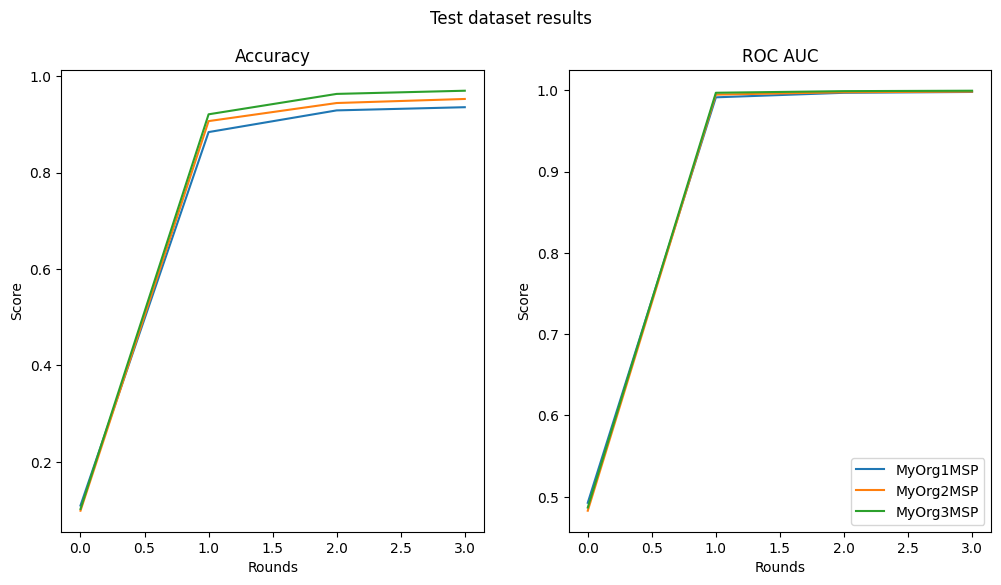

In [18]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle("Test dataset results")

axs[0].set_title("Accuracy")
axs[1].set_title("ROC AUC")

for ax in axs.flat:
    ax.set(xlabel="Rounds", ylabel="Score")


for org_id in DATA_PROVIDER_ORGS_ID:
    org_df = performances_df[performances_df["worker"] == org_id]
    acc_df = org_df[org_df["identifier"] == "Accuracy"]
    axs[0].plot(acc_df["round_idx"], acc_df["performance"], label=org_id)

    auc_df = org_df[org_df["identifier"] == "ROC AUC"]
    axs[1].plot(auc_df["round_idx"], auc_df["performance"], label=org_id)

plt.legend(loc="lower right")
plt.show()

### Download a model

After the experiment, you might be interested in downloading your trained model.
To do so, you will need the source code in order to reload your code architecture in memory.
You have the option to choose the client and the round you are interested in downloading.

If `round_idx` is set to `None`, the last round will be selected by default.



In [19]:
from substrafl.model_loading import download_algo_state

client_to_download_from = DATA_PROVIDER_ORGS_ID[-1]
round_idx = None

algo = download_algo_state(
    client=clients[client_to_download_from],
    compute_plan_key=compute_plan.key,
    round_idx=round_idx,
)

model = algo.model

print(model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)
